## Features selection and dataset preparation

In [241]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

df = pd.read_csv('data.csv')

def plot_bar (colname, df, set_xrange=False, xrange=(0,0), figsize=(9,3)):
    
    # Split the data in positive and negative classes 
    df_pos = df.loc[df['loan_status']==0]
    df_neg = df.loc[df['loan_status']==1]

    # Get features associated with the positive class
    pos_feature = df_pos[colname].value_counts()
    norm_pos_feature = {d:pos_feature[d]/sum(pos_feature.values) for d in dict(pos_feature)}

    # Get features associated with the negative class
    neg_feature = df_neg[colname].value_counts()
    norm_neg_feature = {d:neg_feature[d]/sum(neg_feature.values) for d in dict(neg_feature)}
    
    # Plot probability density distributions for both classes
    fig, axs = plt.subplots(1,1, figsize=figsize)
    axs.bar(norm_pos_feature.keys(), norm_pos_feature.values(), alpha=0.5, label='Paid')
    axs.bar(norm_neg_feature.keys(), norm_neg_feature.values(), alpha=0.5, label='Not paid')
    axs.legend()
    if set_xrange:
        axs.set_xlim(xrange[0],xrange[1])
    plt.title('{} p.d.f'.format(colname))
    
def plot_hist (colname, df, xrange, nbins, xlabel, figsize=(9,3)):
    
    # Split the data in positive and negative classes 
    df_pos = df.loc[df['loan_status']==0]
    df_neg = df.loc[df['loan_status']==1]
    
    # Plot probability density distributions for both classes
    fig, axs = plt.subplots(1,1, figsize=(9,3))
    axs.hist(df_pos[colname].values, bins=nbins, range=xrange, density=True, alpha=0.5, label='Paid')
    axs.hist(df_neg[colname].values, bins=nbins, range=xrange, density=True, alpha=0.5, label='Not paid')
    axs.legend()
    plt.title('{} p.d.f'.format(colname))
    plt.xlabel(xlabel)

### Categorical features:
* Ordinal Data: The categories have an inherent order:
    * emp_length
    * We will apply ordinal encoding for this feature
* Nominal Data: The categories do not have an inherent order:
    * term, home_ownership, verification_status, purpose, zip_code, addr_state, initial_list_status, application_type.
    * We will apply one-hot encoding for these features
    
### Numerical features:
* annual_inc, dti, revol_bal, revol_util, open_acc, pub_rec, total_acc, mort_acc, pub_rec_bankruptcies

In [242]:
# Compute percentage of NaNs
print('Percentage of NaNs for emp_length: {} % '.format(df['emp_length'].isnull().values.sum()*100/df.shape[0]))
print('Percentage of NaNs for zip_code: {} % '.format(df['zip_code'].isnull().values.sum()*100/df.shape[0]))

# Remove missing zip_code values (we don't loose too much data).    
df = df[df['zip_code'].notna()]

# Extract issue year information and add to dataset
df['issue_year'] = df['issue_d'].apply(lambda x: int(str(x).split('-')[1]))
df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda x: int(str(x).split('-')[1]))

Percentage of NaNs for emp_length: 5.8359039923883715 % 
Percentage of NaNs for zip_code: 7.433231002519865e-05 % 


In [252]:
# Split dataset in train/test based on loan_status

label_columns = ['loan_status']

# Selected features based on exploratory data analysis
training_columns = ['emp_length', 'term', 'home_ownership', 'verification_status', 'purpose', 'zip_code',
                    'initial_list_status', 'annual_inc', 'dti',
                    'revol_util', 'open_acc', 'pub_rec', 'total_acc', 'mort_acc', 
                    'pub_rec_bankruptcies', 'issue_year', 'earliest_cr_year']

# Split the training and validation datasets and their labels.
X_train, X_val, y_train, y_val = train_test_split(df[training_columns], df[label_columns],random_state = 1912)

# We want to detect unpaid loans, so we set 'Not paid' label to 1 and 'Paid' to 0
y_train['loan_status'] = y_train['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)
y_val['loan_status'] = y_val['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_val.shape: ', X_val.shape)
print('y_val.shape: ', y_val.shape)
print()
print('#unpaid loans val: ', y_val.loc[y_val['loan_status']==1].shape)
print('#paid loans val: ', y_val.loc[y_val['loan_status']==0].shape)
print('#unpaid loans train: ', y_train.loc[y_train['loan_status']==1].shape)
print('#paid loans train: ', y_train.loc[y_train['loan_status']==0].shape)

X_train.shape:  (1008981, 17)
y_train.shape:  (1008981, 1)
X_val.shape:  (336328, 17)
y_val.shape:  (336328, 1)

#unpaid loans val:  (67014, 1)
#paid loans val:  (269314, 1)
#unpaid loans train:  (201545, 1)
#paid loans train:  (807436, 1)


In [253]:
# Convert emp_length to ordinal values
def convert_emp_length (row):
    if type(row['emp_length']) == float:
        return np.NaN
    if row['emp_length'] == '10+ years':
        return 10
    if row['emp_length'][0] != '<':
        return int(row['emp_length'][0])
    if row['emp_length'] == '< 1 year':
        return 0
    
# Convert issue_year to ordinal values
def convert_issue_year (row):
    # 2006 is the minimum year
    return row['issue_year'] - 2006

# Convert earliest_cr_year to ordinal values
def convert_earliest_cr_year (row):
    # 1934 is the minimum year
    return row['earliest_cr_year'] - 1934

## Perform cleaning and feature engineering tasks on dataset.

In [254]:
def prep_dataset(dataset):
    
    # Get 1st digit from zip_code
    dataset['zip_code_1'] = dataset['zip_code'].apply(lambda x: str(x)[0:1])

    # Remove artificial space from feature 'term'
    dataset['term'] = dataset['term'].apply(lambda x: x if str(x)[0] != ' ' else x[1:])

    # Fill NaNs with the mean for numerical features
    cols = ['annual_inc', 'dti', 'revol_util', 'open_acc', 'pub_rec', 'total_acc', 'mort_acc', 
            'pub_rec_bankruptcies']
    for i in cols:
        dataset[i].fillna(dataset[i].mean(), inplace = True)
    
    # Perform ORDINAL ENCODING for emp_length and issue_year
    dataset['issue_year_mod'] = dataset.apply (lambda row: convert_issue_year(row), axis=1)
    dataset['earliest_cr_year_mod'] = dataset.apply (lambda row: convert_earliest_cr_year(row), axis=1)
    dataset['emp_length_mod'] = dataset.apply (lambda row: convert_emp_length(row), axis=1)
    dataset['emp_length_mod'].fillna(dataset['emp_length_mod'].mean(), inplace = True)
    
    # Perform ONE-HOT ENCODING    
    cols = ['term', 'home_ownership', 'verification_status', 'purpose', 'zip_code_1', 
            'initial_list_status']
    
    for i in cols:
        dummies = pd.get_dummies(dataset[i], prefix = i, drop_first = False)
        dataset = pd.concat([dataset, dummies], axis = 1)
        
    return dataset

X_train = prep_dataset(X_train.copy())
X_val = prep_dataset(X_val.copy())
X_train.head(5)

,emp_length,term,home_ownership,verification_status,purpose,zip_code,initial_list_status,annual_inc,dti,revol_util,open_acc,pub_rec,total_acc,mort_acc,pub_rec_bankruptcies,issue_year,earliest_cr_year,zip_code_1,issue_year_mod,earliest_cr_year_mod,emp_length_mod,term_36 months,term_60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,zip_code_1_0,zip_code_1_1,zip_code_1_2,zip_code_1_3,zip_code_1_4,zip_code_1_5,zip_code_1_6,zip_code_1_7,zip_code_1_8,zip_code_1_9,initial_list_status_f,initial_list_status_w
1241974,3 years,36 months,RENT,Source Verified,credit_card,989xx,f,45000.0,12.67,20.1,12.0,1.0,14.0,0.000000,0.0,2016,2011,9,10,77,3.0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1189799,10+ years,36 months,RENT,Source Verified,debt_consolidation,424xx,f,84198.0,20.09,51.1,14.0,0.0,43.0,1.670772,0.0,2012,1990,4,6,56,10.0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1130069,3 years,36 months,RENT,Not Verified,credit_card,926xx,f,78000.0,15.72,60.8,21.0,0.0,44.0,0.000000,0.0,2013,2000,9,7,66,3.0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
434815,1 year,36 months,RENT,Source Verified,credit_card,786xx,w,33280.0,21.60,46.4,9.0,0.0,17.0,0.000000,0.0,2017,2010,7,11,76,1.0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
790599,1 year,60 months,MORTGAGE,Not Verified,debt_consolidation,276xx,f,58000.0,26.76,24.8,29.0,0.0,44.0,3.000000,0.0,2014,1997,2,8,63,1.0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


## Drop unused columns from this dataset.

In [255]:
# Drop unused columns from this dataset.
def drop_unused(dataset):
    
    # This has been replaced with ordinal encoding.
    dataset = dataset.drop(['emp_length'], axis = 1)

    # These have been replaced with one-hot encoding.
    dataset = dataset.drop(['term'], axis = 1)
    dataset = dataset.drop(['home_ownership'], axis = 1)
    dataset = dataset.drop(['verification_status'], axis = 1)
    dataset = dataset.drop(['purpose'], axis = 1)
    dataset = dataset.drop(['zip_code'], axis = 1)
    dataset = dataset.drop(['zip_code_1'], axis = 1)
    dataset = dataset.drop(['earliest_cr_year'], axis = 1)
    dataset = dataset.drop(['issue_year'], axis = 1)
    dataset = dataset.drop(['initial_list_status'], axis = 1)
    
    return dataset

X_train = drop_unused(X_train.copy())
X_val = drop_unused(X_val.copy())

print('X_train.shape: ', X_train.shape)
print('X_val.shape: ', X_val.shape)
X_train.head(10)

X_train.shape:  (1008981, 48)
X_val.shape:  (336328, 48)


,annual_inc,dti,revol_util,open_acc,pub_rec,total_acc,mort_acc,pub_rec_bankruptcies,issue_year_mod,earliest_cr_year_mod,emp_length_mod,term_36 months,term_60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,zip_code_1_0,zip_code_1_1,zip_code_1_2,zip_code_1_3,zip_code_1_4,zip_code_1_5,zip_code_1_6,zip_code_1_7,zip_code_1_8,zip_code_1_9,initial_list_status_f,initial_list_status_w
1241974,45000.0,12.67,20.1,12.0,1.0,14.0,0.000000,0.0,10,77,3.0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1189799,84198.0,20.09,51.1,14.0,0.0,43.0,1.670772,0.0,6,56,10.0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1130069,78000.0,15.72,60.8,21.0,0.0,44.0,0.000000,0.0,7,66,3.0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
434815,33280.0,21.60,46.4,9.0,0.0,17.0,0.000000,0.0,11,76,1.0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
790599,58000.0,26.76,24.8,29.0,0.0,44.0,3.000000,0.0,8,63,1.0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1257899,80000.0,20.28,92.2,18.0,0.0,23.0,0.000000,0.0,11,74,10.0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
947127,120000.0,8.16,28.6,14.0,0.0,36.0,1.670772,0.0,4,54,2.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
135607,170000.0,18.06,54.9,11.0,1.0,39.0,7.000000,1.0,9,64,10.0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
378148,75000.0,17.94,65.0,24.0,0.0,39.0,0.000000,0.0,12,73,1.0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1114909,95000.0,7.04,82.1,4.0,0.0,14.0,3.000000,0.0,7,58,0.0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


## Select the most important features to use for training

In [256]:
# Drop not important features from this dataset (based on a previous run iteration).
def drop_not_important(dataset):
    
    dataset = dataset.drop(['home_ownership_ANY'], axis = 1)
    dataset = dataset.drop(['home_ownership_NONE'], axis = 1)
    dataset = dataset.drop(['home_ownership_OTHER'], axis = 1)
    dataset = dataset.drop(['home_ownership_OWN'], axis = 1)
    dataset = dataset.drop(['verification_status_Not Verified'], axis = 1)
    dataset = dataset.drop(['purpose_car'], axis = 1)
    dataset = dataset.drop(['purpose_educational'], axis = 1) 
    dataset = dataset.drop(['purpose_house'], axis = 1)
    dataset = dataset.drop(['purpose_major_purchase'], axis = 1)
    dataset = dataset.drop(['purpose_medical'], axis = 1)
    dataset = dataset.drop(['purpose_moving'], axis = 1)
    dataset = dataset.drop(['purpose_renewable_energy'], axis = 1)
    dataset = dataset.drop(['purpose_small_business'], axis = 1)
    dataset = dataset.drop(['purpose_vacation'], axis = 1)
    dataset = dataset.drop(['purpose_wedding'], axis = 1)
    
    dataset = dataset.drop(['purpose_home_improvement'], axis = 1)
    dataset = dataset.drop(['purpose_other'], axis = 1)
    
    return dataset

X_train = drop_not_important(X_train.copy())
X_val = drop_not_important(X_val.copy())

print('X_train.shape:: ', X_train.shape)
print('X_val.shape:', X_val.shape)
X_train.head(10)

(1008981, 31)
(336328, 31)


,annual_inc,dti,revol_util,open_acc,pub_rec,total_acc,mort_acc,pub_rec_bankruptcies,issue_year_mod,earliest_cr_year_mod,emp_length_mod,term_36 months,term_60 months,home_ownership_MORTGAGE,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,zip_code_1_0,zip_code_1_1,zip_code_1_2,zip_code_1_3,zip_code_1_4,zip_code_1_5,zip_code_1_6,zip_code_1_7,zip_code_1_8,zip_code_1_9,initial_list_status_f,initial_list_status_w
1241974,45000.0,12.67,20.1,12.0,1.0,14.0,0.000000,0.0,10,77,3.0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
1189799,84198.0,20.09,51.1,14.0,0.0,43.0,1.670772,0.0,6,56,10.0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1130069,78000.0,15.72,60.8,21.0,0.0,44.0,0.000000,0.0,7,66,3.0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
434815,33280.0,21.60,46.4,9.0,0.0,17.0,0.000000,0.0,11,76,1.0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
790599,58000.0,26.76,24.8,29.0,0.0,44.0,3.000000,0.0,8,63,1.0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
1257899,80000.0,20.28,92.2,18.0,0.0,23.0,0.000000,0.0,11,74,10.0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
947127,120000.0,8.16,28.6,14.0,0.0,36.0,1.670772,0.0,4,54,2.0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
135607,170000.0,18.06,54.9,11.0,1.0,39.0,7.000000,1.0,9,64,10.0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0
378148,75000.0,17.94,65.0,24.0,0.0,39.0,0.000000,0.0,12,73,1.0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
1114909,95000.0,7.04,82.1,4.0,0.0,14.0,3.000000,0.0,7,58,0.0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0


## Cross-check distributions after data processing

In [257]:
df_check = pd.concat([X_train, X_val])
df_check['loan_status'] = pd.concat([y_train, y_val])
df_check.head(5)

,annual_inc,dti,revol_util,open_acc,pub_rec,total_acc,mort_acc,pub_rec_bankruptcies,issue_year_mod,earliest_cr_year_mod,emp_length_mod,term_36 months,term_60 months,home_ownership_MORTGAGE,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,zip_code_1_0,zip_code_1_1,zip_code_1_2,zip_code_1_3,zip_code_1_4,zip_code_1_5,zip_code_1_6,zip_code_1_7,zip_code_1_8,zip_code_1_9,initial_list_status_f,initial_list_status_w,loan_status
1241974,45000.0,12.67,20.1,12.0,1.0,14.0,0.000000,0.0,10,77,3.0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1189799,84198.0,20.09,51.1,14.0,0.0,43.0,1.670772,0.0,6,56,10.0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
1130069,78000.0,15.72,60.8,21.0,0.0,44.0,0.000000,0.0,7,66,3.0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
434815,33280.0,21.60,46.4,9.0,0.0,17.0,0.000000,0.0,11,76,1.0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
790599,58000.0,26.76,24.8,29.0,0.0,44.0,3.000000,0.0,8,63,1.0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1


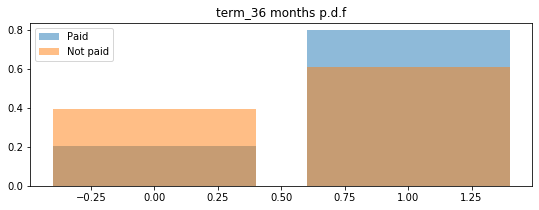

In [258]:
plot_bar('term_36 months', df_check.copy())

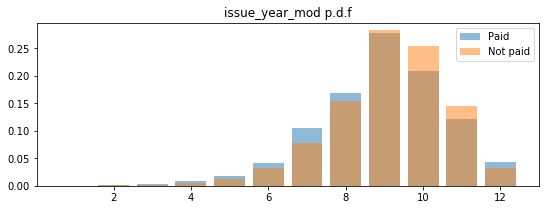

In [259]:
plot_bar('issue_year_mod', df_check.copy())

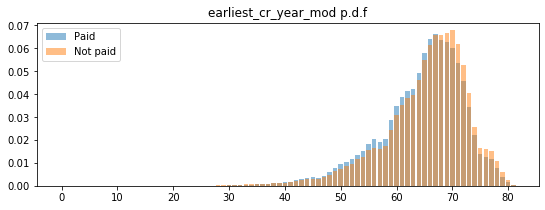

In [260]:
plot_bar('earliest_cr_year_mod', df_check.copy())

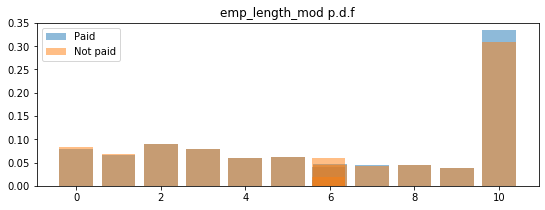

In [261]:
plot_bar('emp_length_mod', df_check.copy())

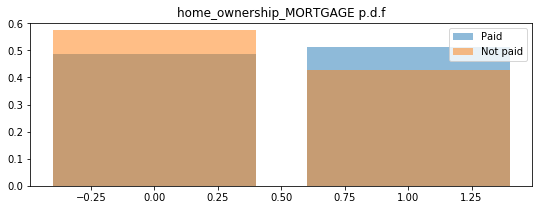

In [262]:
plot_bar('home_ownership_MORTGAGE', df_check.copy())

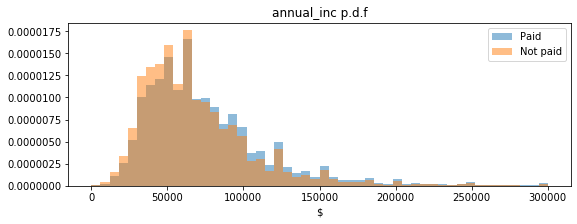

In [263]:
plot_hist ('annual_inc', df_check.copy(), (0,0.3e6), 50, '\$')

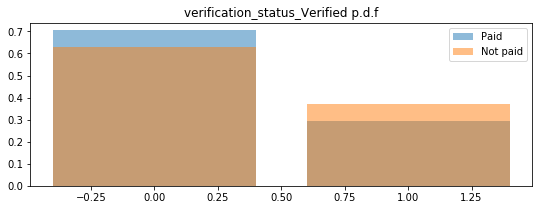

In [264]:
plot_bar('verification_status_Verified', df_check.copy())

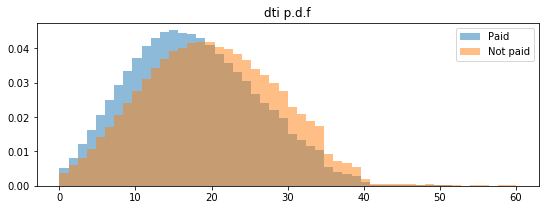

In [265]:
plot_hist ('dti', df_check.copy(), (0,60), 50, '')

## Create a basic Decision Tree predictor

In [267]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from time import time

tree = DecisionTreeClassifier(random_state = 1111)
start = time()
tree.fit(X_train, np.ravel(y_train))
end = time()
train_time = (end - start) * 1000

prediction = tree.predict(X_val)

# Score using the validation data.
score = tree.score(X_val, y_val)

print('Decision tree model took {:.2f} milliseconds to fit.'.format(train_time))
print('Accuracy: {:.0f}%'.format(score * 100))

Decision tree model took 11359.94 milliseconds to fit.
Accuracy: 69%


## Define metrics: accuracy, precision, recall, and F<sub>1</sub> score

In [268]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def model_scores(y, prediction):
    acc = accuracy_score(y, prediction)
    print('Accuracy: {:.0f}%'.format(np.round(acc * 100)))
    
    precision = precision_score(y, prediction)
    print('Precision: {:.0f}%'.format(np.round(precision * 100)))
    
    recall = recall_score(y, prediction)
    print('Recall: {:.0f}%'.format(np.round(recall * 100)))
    
    f1 = f1_score(y, prediction)
    print('F1: {:.0f}%'.format(np.round(f1 * 100)))

## Define ROC curve function and compute the AUC

In [269]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def roc(y, prediction_proba):
    fpr, tpr, thresholds = roc_curve(y, prediction_proba)
    
    plt.plot(fpr, tpr);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.0]);
    plt.title('ROC Curve');
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.grid(True);
    
    auc = roc_auc_score(y, prediction_proba)
    print('Area Under Curve: {:.2f}'.format(auc))

## Define precision–recall curve function and compute the average precision

In [270]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def prc(y, prediction_proba):
    precision, recall, thresholds = precision_recall_curve(y, prediction_proba)
    
    plt.plot(recall, precision);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.0]);
    plt.title('Precision–Recall Curve');
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.grid(True);
    
    ap = average_precision_score(y, prediction_proba)
    print('Average Precision: {:.2f}'.format(ap))

## Evaluate initial DecisionTree model

In [272]:
print('Evaluation in the training set')
initial_predict = tree.predict(X_train)
model_scores(y_train, initial_predict)

Evaluation in the training set
Accuracy: 100%
Precision: 100%
Recall: 100%
F1: 100%


In [273]:
print('Evaluation in the val set')
initial_predict = tree.predict(X_val)
model_scores(y_val, initial_predict)

Evaluation in the val set
Accuracy: 69%
Precision: 26%
Recall: 28%
F1: 27%


Area Under Curve: 0.54


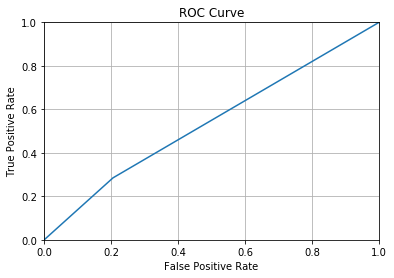

In [274]:
# Plot ROC for validation data
initial_predict_proba = tree.predict_proba(X_val)
roc(y_val, initial_predict_proba[:, 1])

Average Precision: 0.22


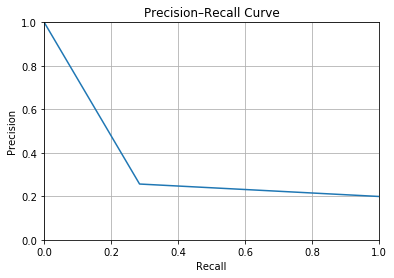

In [275]:
# Plot PR for validation data
prc(y_val, initial_predict_proba[:, 1])

### Plot confusion matrix (decision tree model)

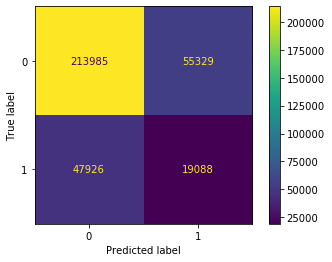

In [276]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(tree, X_val, y_val)

## Create a RandomForestClassifier

In [277]:
from sklearn.ensemble import RandomForestClassifier

from time import time


forest = RandomForestClassifier(n_estimators=77,
                               max_depth= 14,
                               min_samples_split= 26,
                               min_samples_leaf= 38,
                               class_weight= 'balanced',
                               criterion= 'entropy')

# Best params found with RandomSearchCV:
# {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13, 
#'min_samples_leaf': 16, 'min_samples_split': 4, 'n_estimators': 36}

# Best params found with BayesianOptimization:
# {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 
# 'min_samples_leaf': 38, 'min_samples_split': 26, 'n_estimators': 77}

start = time()
forest.fit(X_train, np.ravel(y_train))
end = time()
train_time = (end - start) * 1000

prediction = forest.predict(X_val)

# Score using the validation data.
score = forest.score(X_val, y_val)

print('RandomForest model took {:.2f} milliseconds to fit.'.format(train_time))
print('Accuracy: {:.0f}%'.format(score * 100))

RandomForest model took 76379.91 milliseconds to fit.
Accuracy: 67%


## RandomSearchCV for hyperparameters (commented)

In [138]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint as sp_randint

# dist = {'criterion': ['gini', 'entropy'],
#         'max_depth': sp_randint(4, 15),
#         'n_estimators': sp_randint(5, 40),
#         'min_samples_split': sp_randint(2, 20),
#         'min_samples_leaf': sp_randint(1, 20),
#        'class_weight': ['balanced', None]}


# search = RandomizedSearchCV(forest, param_distributions = dist, n_iter = 300, 
#                             scoring = 'f1', cv = 3, random_state = 1912)
# search.fit(X_train, np.ravel(y_train));
# optimized_forest = search.best_estimator_

# print(search.best_params_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 16, 'min_samples_split': 4, 'n_estimators': 36}


In [278]:
print('Evaluation in the val set')
optimized_predict = forest.predict(X_val)
model_scores(y_val, prediction)

Evaluation in the val set
Accuracy: 67%
Precision: 32%
Recall: 58%
F1: 41%


* RandomForest F1-score: 41%
* DecisionTree F1-score: 27%

Area Under Curve: 0.69


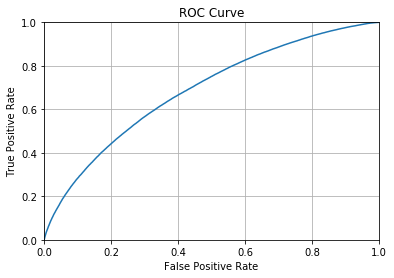

In [279]:
predict_proba = forest.predict_proba(X_val)
roc(y_val, predict_proba[:, 1])

* RandomForest AUC-ROC: 69%
* DecisionTree AUC-ROC: 54%

Average Precision: 0.36


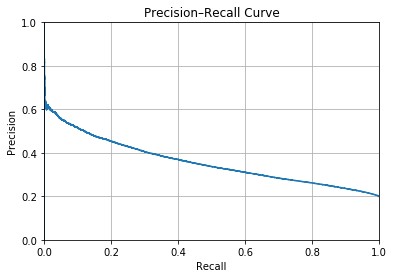

In [280]:
prc(y_val, predict_proba[:, 1])

* RandomForest Average Precision: 36%
* DecisionTree Average Precision: 22%

## Identify important features from feature_importances

In [281]:
# Get feature importances.
feature_importances = list(forest.feature_importances_)

# Get column names.
feature_list = list(X_train)

importances_list = []

# Map feature/importance indices and put into a single list.
for feature, importance in zip(feature_list, feature_importances):
    importances_list.append((feature, round(importance, 2)))

# Sort list by importance index.
importances_list = sorted(importances_list, key = lambda i: i[1], reverse = True)

for feature, importance in importances_list:
    print('Feature: {:10} | Importance: {}'.format(feature, importance))

Feature: term_36 months | Importance: 0.17
Feature: term_60 months | Importance: 0.15
Feature: dti        | Importance: 0.12
Feature: annual_inc | Importance: 0.07
Feature: revol_util | Importance: 0.07
Feature: issue_year_mod | Importance: 0.07
Feature: mort_acc   | Importance: 0.06
Feature: earliest_cr_year_mod | Importance: 0.04
Feature: open_acc   | Importance: 0.03
Feature: total_acc  | Importance: 0.03
Feature: home_ownership_MORTGAGE | Importance: 0.03
Feature: verification_status_Verified | Importance: 0.03
Feature: emp_length_mod | Importance: 0.02
Feature: home_ownership_RENT | Importance: 0.02
Feature: verification_status_Source Verified | Importance: 0.02
Feature: pub_rec    | Importance: 0.01
Feature: pub_rec_bankruptcies | Importance: 0.01
Feature: purpose_credit_card | Importance: 0.01
Feature: purpose_debt_consolidation | Importance: 0.01
Feature: zip_code_1_9 | Importance: 0.01
Feature: initial_list_status_f | Importance: 0.01
Feature: initial_list_status_w | Importanc

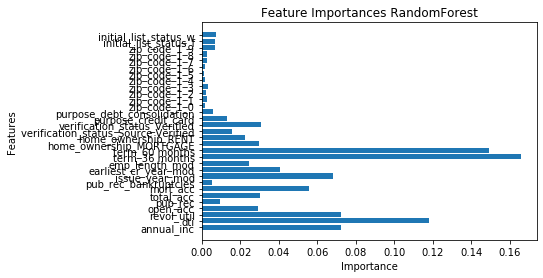

In [285]:
y_values = list(range(len(feature_importances)))
plt.barh(y_values, feature_importances)
plt.yticks(y_values, feature_list, rotation='horizontal')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances RandomForest');

* The important features found by the RandomForest are the expected ones (more discriminative) based on the exploratory analysis

### Plot confusion matrix (Random Forest model)

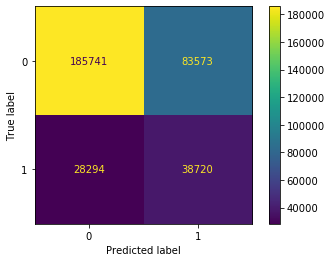

In [286]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(forest, X_val, y_val)